### Single run of abyss

In [1]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R5/step2_params'

### Import the truth: data

This will involve reading in sediment depth measurements and potentially other morphologic parameters. This should ultimately be called, in Benoit's framework, ds_out_true

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import xsimlab as xs

### Define the xsimlab model


In [3]:
@xs.process
class UniformGrid1D:
    """Create 1D model grid with uniform spacing"""
    
    #grid parameters
    spacing = xs.variable(description="grid_spacing", static=True)
    length = xs.variable(description="grid total length", static=True)
    
    #x is an index variable, used for accessing the grid.
    x = xs.index(dims="x")
    
    #create the grid
    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [4]:
@xs.process
class ProfileZ:
    """Compute the evolution of the elevation (z) profile"""
    
    h_vars = xs.group("h_vars") #allows for multiple processes influencing; say diffusion and subsidence
    #br_vars = xs.group("br_vars") #allows for multiple processes influencing; say diffusion and subsidence

    z = xs.variable(
        dims="x", intent="inout", description="surface elevation z", attrs={"units": "m"}
    )
    #br = xs.variable(
    #    dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    #)
    br = xs.variable(
        dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    )
    h = xs.variable(
        dims="x", intent="inout", description="sed_thickness", attrs={"units": "m"}
    )

    def run_step(self):
        #self._delta_br = sum((br for br in self.br_vars))
        self._delta_h = sum((h for h in self.h_vars))

    def finalize_step(self):
        #self.br += self._delta_br #update bedrock surface
        self.h += self._delta_h #update sediment thickness
        self.z = self.br + self.h #add sediment to bedrock to get topo elev.

In [5]:
@xs.process
class ErosionDeposition:
    """Here's where the actual computation happens: nonlocal diffusion

    """
    
    #get input parameters
    basin_width = xs.variable(description="basin width")
    sea_level = xs.variable(description="sea level")
    k_factor = xs.variable(description="k factor")
    k_depth_scale = xs.variable(description="k depth scale")
    travel_dist = xs.variable(description="marine_travel_distance")
    s_crit = xs.variable(description="marine_critical_slope")
    sed_porosity = xs.variable(description="marine_sediment_porosity")
    sed_porosity_depth_scale = xs.variable(description="marine_sediment_porosity_depth_scale")
    qs_in = xs.variable(description="sediment_flux_in")
    
    slope = xs.variable(
        dims="x", intent="out", description="topographic_slope", attrs={"units": "-"}
    )
    depth = xs.variable(
        dims="x", intent="out", description="depth", attrs={"units": "m"}
    )
    erosion = xs.variable(
        dims="x", intent="out", description="erosion", attrs={"units": "m/yr"}
    )
    deposition = xs.variable(
        dims="x", intent="out", description="deposition", attrs={"units": "m/yr"}
    )
    dh_dt = xs.variable(
        dims="x", intent="out", description="dh_dt", attrs={"units": "m/yr"}
    )
    qs = xs.variable(
        dims="x", intent="out", description="qs", attrs={"units": "m2/yr"}
    )
    #dbr = xs.variable(dims="x", intent="out", groups="br_vars")
    dh = xs.variable(dims="x", intent="out", groups="h_vars")
    
    spacing = xs.foreign(UniformGrid1D, "spacing")
    #x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z")
    br = xs.foreign(ProfileZ, "br")
    h = xs.foreign(ProfileZ, "h")
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):

        self.erosion = np.repeat(0., len(self.z))
        self.deposition = np.repeat(0., len(self.z))
        self.dh_dt = np.repeat(0., len(self.z))
        self.qs = np.repeat(0., len(self.z))
        self.dh = np.repeat(0., len(self.z))
        
        #divide Qs_in by basin width to get qs_in
        qs_in = self.qs_in / self.basin_width
        
        #calculate topographic slope
        self.slope = np.append(np.diff(self.z) / self.spacing, 0)
        #calculate depth below water
        self.depth = np.maximum(self.sea_level - self.z, 0)
        
        #calculate k array
        k_arr = self.k_factor * np.exp(-self.depth / self.k_depth_scale)
        
        #impose hard basin floor
        k_arr[self.z <= (self.br + 0.001)] = 0
        
        #find first marine node
        marine_or_terrestrial = self.z <= self.sea_level #boolean: true is marine
        first_marine_node = np.argmax(marine_or_terrestrial) #finds the first true
        
        #evolve first marine node
        if self.slope[first_marine_node] <= 0: #this is the "regular," right-draining case
            self.erosion[first_marine_node] = k_arr[first_marine_node] * np.abs(self.slope[first_marine_node])
            self.deposition[first_marine_node] = (qs_in * (1 - np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist

        else:  #this is the irregular, left-draining case
            self.erosion[first_marine_node] = 0 #because slope = 0
            self.deposition[first_marine_node] = qs_in / self.spacing #(self.qs_in * (1 + np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist #because slope = 0 #self.qs_in / self.travel_dist
        self.dh_dt[first_marine_node] = (-self.erosion[first_marine_node] + self.deposition[first_marine_node]) / (1 - self.sed_porosity)
        self.dh[first_marine_node] = self.dh_dt[first_marine_node] * dt
        self.qs[first_marine_node] = np.maximum(qs_in + (self.erosion[first_marine_node] - self.deposition[first_marine_node]) * self.spacing, 0.)
        if -self.dh[first_marine_node] > self.h[first_marine_node]:
            self.dh[first_marine_node] = -self.h[first_marine_node]
            self.qs[first_marine_node] = np.maximum(qs_in + ((-self.dh[first_marine_node] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
        
        
        
        #evolve remaining marine nodes
        for i in range(first_marine_node + 1, len(self.z)): #iterate over each element of x ONLY IN THE MARINE
        
            if self.slope[i] <= 0: #this is the "regular," right-draining case
                self.deposition[i] = (self.qs[i-1] * (1 - np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.travel_dist
                self.erosion[i] = k_arr[i] * np.abs(self.slope[i])
                if self.z[i] > self.sea_level:
                    self.deposition[i] = 0
            else: #this is the irregular, left-draining case
                self.deposition[i] = self.qs[i-1] / self.spacing#(self.qs[i-1] * (1 + np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.spacing#self.travel_dist #self.qs[i-1] / self.spacing
                self.erosion[i] = 0
                if self.z[i] > self.sea_level:
                    self.deposition[i] = 0
            self.dh_dt[i] = (-self.erosion[i] + self.deposition[i]) / (1 - self.sed_porosity)
            
            self.dh[i] = self.dh_dt[i] * dt
            
            self.qs[i] = np.maximum(self.qs[i-1] + (self.erosion[i] - self.deposition[i]) * self.spacing, 0.)
            
            if -self.dh[i] > self.h[i]:
                self.dh[i] = -self.h[i]
                self.qs[i] = np.maximum(self.qs[i-1] + ((-self.dh[i] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
            
        #calculate change in sed thickness
        #self.dh[:first_marine_node] = 0
        #self.dh[first_marine_node:] = self.dh_dt[first_marine_node:] * dt
        #self.dh[self.erosion > self.h] = -self.h[self.erosion > self.h] #if erosion is greater than h, topo only loses h    
        
        #compact sediment
        #calculate the thickness after compaction, z0; dh is the thickness of new deposited solid sediment
        dh_compact = self.dh * (1 - self.sed_porosity)
    
        
        #compaction routine
        #def compaction(porosity, porosity_depth_scale, nn, dh, zi):
        nn = len(self.z)
        z0 = np.zeros(nn)
        #set initial guess for z0:
        z0[:] = self.h[:]

        #Newton-Raphson iteration  at every node
        for k in range(nn):
            fx = 1 #throwaway initial value to trigger "while" loop
            dfx = 1 #throwaway initial value to trigger "while" loop
            #check whether we're at the root
            if dh_compact[k] > 0 : #only apply compaction where deposition is happening
                while np.abs(fx / dfx) > 1e-6:
                    #calculate value of function at initial guess
                    fx = z0[k] - self.h[k] + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - dh_compact[k]
        
                    #calculate derivative
                    dfx = 1 - self.sed_porosity * np.exp(-z0[k] / self.sed_porosity_depth_scale)
                    z0[k] = z0[k] - fx / dfx

            elif dh_compact[k] == 0: #no e or d
                z0[k] = self.h[k]
            else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
                z0[k] = self.h[k] + dh_compact[k] / (1 - self.sed_porosity)
        
        #here, have a chance to set the final dh by differencing new h (z0) and old h (h)
        self.dh[:] = z0[:] - self.h[:]
        
        #finalize changes to bedrock (subsidence) and sediment thickness (e/d)
        #self.dbr = (self.subsidence * dt)

In [6]:
@xs.process
class InitBasinGeom:
    """
    Give initial basin elevation field as a function of x:
    z = exp(- (x - a) / b) + c
    """
    
    #a = xs.variable(description="shift parameter", static=True)
    #b = xs.variable(description="scale parameter", static=True)
    #c = xs.variable(description="initial basin floor altitude", static=True)
    #d = xs.variable(description="x multiplier", static=True)

    init_br = xs.variable(dims="x", description="shift parameter", static=True)
    
    x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z", intent="out")
    #br = xs.foreign(ProfileZ, "br", intent="in")
    h = xs.foreign(ProfileZ, "h", intent="out")

    def initialize(self):
        #self.br = np.exp(- (self.x * self.d - self.a) / self.b) + self.c #build the initial topography
        self.h = np.zeros(len(self.x)) #initial sediment thickness is 0
        self.z = np.zeros(len(self.x)) + self.init_br #self.br#(np.exp(- (self.x * self.d - self.a) / self.b) + self.c) + self.h

In [7]:
marine = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileZ,
        "init": InitBasinGeom,
        "erode": ErosionDeposition,
    }
)

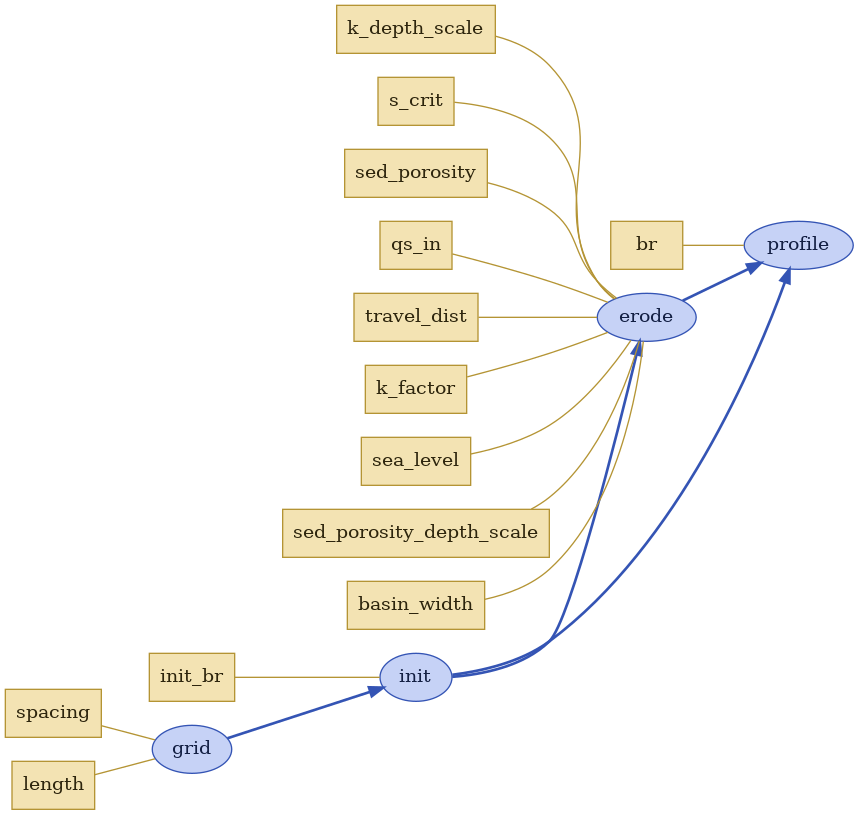

In [8]:
marine.visualize(show_inputs=True)

In [9]:
#need to import basement elevation and qs time series after they were exported by the prepro notebook
bedrock_file = '../prepro/bedrock_elev_array.npy'
br = np.load(bedrock_file)
bedrock_elev_array = xr.DataArray(br, dims=['time', 'x'])
initial_bedrock = bedrock_elev_array[0, :]

qs_file = '../prepro/qs_array.npy'
qs_array = np.load(qs_file)
qs_array = xr.DataArray(qs_array, dims=['time'])
#this is loading in the full m3/yr numbers directly from Baby et al 2019.


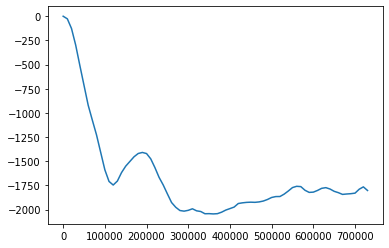

In [10]:
x = np.arange(0, 740000, 10000)
plt.plot(x,bedrock_elev_array[0, :])

In [12]:
best_fit_params

array([2.10129713e+05, 2.61722706e-02, 9.54370210e+01, 2.63355285e-02])

In [13]:
in_ds = xs.create_setup(
   ...:     model=marine,
   ...:     clocks={
   ...:         'time': np.arange(0, 130000000, 1000),
   ...:         'otime': np.append(np.arange(0, 130000000, 1000000), 129999000) #np.array([19999000])
   ...:     },
   ...:     master_clock='time',
   ...:     input_vars={
   ...:         'grid': {'length': 740000., 'spacing': 10000.},
                'init': {'init_br': initial_bedrock},
                'erode': {
                    'k_factor': 0.5,
                    'k_depth_scale': 75.,
                    's_crit': 0.04,
                    'travel_dist': 200000.,
                    'sed_porosity': 0.56,
                    'sed_porosity_depth_scale': 2830.,
                    'sea_level': 0.,
                    'qs_in': qs_array,
                    'basin_width': 1.0
                },
                'profile': {
                    'br': bedrock_elev_array
                },
   },
            output_vars={'profile__z': 'otime', 'profile__br': 'otime', 'profile__h': 'otime'}
)

### Here we import the data that will be used to calculate model misfit

In [14]:
sed_surfaces = np.load('../prepro/all_surfaces.npy')
top_surface = sed_surfaces[-1, :] #this is the top of the U8 surface
br_surface = sed_surfaces[0, :]



In [15]:
with marine: 
    out_ds = in_ds.xsimlab.run(store="bestfit_param_simulation.zarr")

In [16]:
#calc misfit
obs_h = sed_surfaces[-1, :] - sed_surfaces[0, :]
misfit = np.sqrt((1/73) * np.sum(np.power(obs_h[1:] - out_ds.profile__h[-1, 1:], 2)/np.power(10,2)))
print(np.float(misfit))

8.437511704726486


(0.0, 1400000.0)

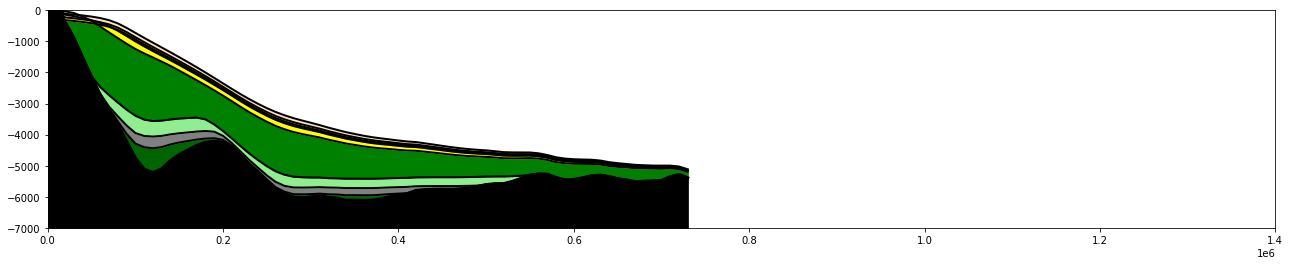

In [17]:
batch_flag=0
if batch_flag == 1:
    for i in range(n_runs):

        #plot stratigraphy adjusted for later subsidence
        plt.figure(figsize=(22,2))
        final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[i,-1, :], linewidth = 3, color = 'k')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
        br_diff0000 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,129, :]
        br_diff000 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,119, :]
        br_diff00 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,100, :]
        br_diff0 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,64, :]
        br_diff1 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,49, :]
        br_diff2 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,36, :]
        br_diff3 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,30, :]
        br_diff4 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,17, :]
        plt.plot(out_ds.x, out_ds.profile__z[i,129, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,119, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,100, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,64, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,49, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,36, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,30, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,17, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

        #fill in all the strata
        plt.fill_between(out_ds.x, out_ds.profile__br[i,-1, :], out_ds.profile__z[i,17, :] + br_diff4, color = 'darkgreen')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,17, :] + br_diff4, out_ds.profile__z[i,30, :] + br_diff3, color = 'gray')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,30, :] + br_diff3, out_ds.profile__z[i,36, :] + br_diff2, color = 'lightgreen')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,36, :] + br_diff2, out_ds.profile__z[i,49, :] + br_diff1, color = 'green')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,49, :] + br_diff1, out_ds.profile__z[i,64, :] + br_diff0, color = 'yellow')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,64, :] + br_diff0, out_ds.profile__z[i,100, :] + br_diff00, color = 'orange')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,100, :] + br_diff00, out_ds.profile__z[i,119, :] + br_diff000, color = 'gold')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,119, :] + br_diff000, out_ds.profile__z[i,129, :] + br_diff0000, color = 'bisque')
        plt.fill_between(out_ds.x, -7000, out_ds.profile__br[i,-1, :], color = 'k')

else: #not batched
    #plot stratigraphy adjusted for later subsidence
    plt.figure(figsize=(22,4))
    final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[-1, :], linewidth = 3, color = 'k')
    #plt.plot(out_ds.x, out_ds.profile__z[-1, :], linewidth = 3, color = 'k', linestyle='--')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
    br_diff0000 = out_ds.profile__br[-1, :] - out_ds.profile__br[129, :]


    br_diff000 = out_ds.profile__br[-1, :] - out_ds.profile__br[119, :]


    br_diff00 = out_ds.profile__br[-1, :] - out_ds.profile__br[100, :]


    br_diff0 = out_ds.profile__br[-1, :] - out_ds.profile__br[64, :]


    br_diff1 = out_ds.profile__br[-1, :] - out_ds.profile__br[49, :]
    br_diff2 = out_ds.profile__br[-1, :] - out_ds.profile__br[36, :]

    br_diff3 = out_ds.profile__br[-1, :] - out_ds.profile__br[30, :]


    br_diff4 = out_ds.profile__br[-1, :] - out_ds.profile__br[17, :]
    plt.plot(out_ds.x, out_ds.profile__z[130, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')

    plt.plot(out_ds.x, out_ds.profile__z[119, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[100, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[64, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[49, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[36, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[30, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[17, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

    #fill in all the strata
    plt.fill_between(out_ds.x, out_ds.profile__br[-1, :], out_ds.profile__z[17, :] + br_diff4, color = 'darkgreen')
    plt.fill_between(out_ds.x, out_ds.profile__z[17, :] + br_diff4, out_ds.profile__z[30, :] + br_diff3, color = 'gray')
    plt.fill_between(out_ds.x, out_ds.profile__z[30, :] + br_diff3, out_ds.profile__z[36, :] + br_diff2, color = 'lightgreen')
    plt.fill_between(out_ds.x, out_ds.profile__z[36, :] + br_diff2, out_ds.profile__z[49, :] + br_diff1, color = 'green')
    plt.fill_between(out_ds.x, out_ds.profile__z[49, :] + br_diff1, out_ds.profile__z[64, :] + br_diff0, color = 'yellow')
    plt.fill_between(out_ds.x, out_ds.profile__z[64, :] + br_diff0, out_ds.profile__z[100, :] + br_diff00, color = 'orange')
    plt.fill_between(out_ds.x, out_ds.profile__z[100, :] + br_diff00, out_ds.profile__z[119, :] + br_diff000, color = 'gold')
    plt.fill_between(out_ds.x, out_ds.profile__z[119, :] + br_diff000, out_ds.profile__z[129, :] + br_diff0000, color = 'bisque')
    plt.fill_between(out_ds.x, -7000, out_ds.profile__br[-1, :], color = 'k')
    #plt.scatter(150000, sed_surfaces[8, 15], color = 'r')
    #plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
    #plt.scatter(200000, sed_surfaces[8, 20], color = 'r')

    #plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
    #plt.scatter(600000, sed_surfaces[8, 60], color = 'r', zorder = 5)
    #plt.scatter(900000, sed_surfaces[8, 90], color = 'r')
    #plt.plot(out_ds.x, out_ds.profile__z[-110, :], linewidth = 3, color = 'g', linestyle=':')

plt.ylim(-7000, 0)
plt.xlim(0, 1400000)

#plt.ylim(-1000, 0)
#plt.xlim(0, 100000)

(0.0, 1400000.0)

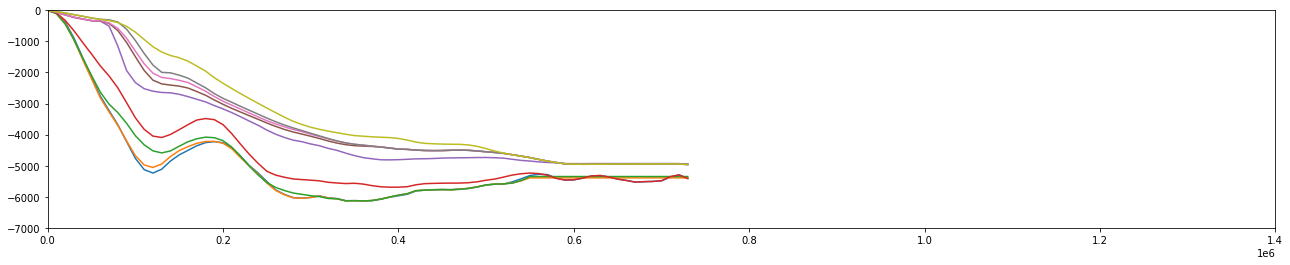

In [18]:
sed_surfaces = np.load('../prepro/all_surfaces.npy')
top_surface = sed_surfaces[-1, :] #this is the top of the U8 surface
br_surface = sed_surfaces[0, :]
plt.figure(figsize=(22,4))
plt.plot(out_ds.x, sed_surfaces[0, :])
plt.plot(out_ds.x, sed_surfaces[1, :])
plt.plot(out_ds.x, sed_surfaces[2, :])
plt.plot(out_ds.x, sed_surfaces[3, :])
plt.plot(out_ds.x, sed_surfaces[4, :])
plt.plot(out_ds.x, sed_surfaces[5, :])
plt.plot(out_ds.x, sed_surfaces[6, :])
plt.plot(out_ds.x, sed_surfaces[7, :])
plt.plot(out_ds.x, sed_surfaces[8, :])
#plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
#plt.scatter(200000, sed_surfaces[8, 20], color = 'r')
#plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
#plt.scatter(600000, sed_surfaces[8, 60], color = 'r')
#plt.scatter(1100000, sed_surfaces[8, 110], color = 'r')
plt.ylim(-7000, 0)
plt.xlim(0, 1400000)
#plt.ylim(-2000, 0)
#plt.xlim(0, 200000)

In [19]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R5/step2_params'

-247.67354560095373


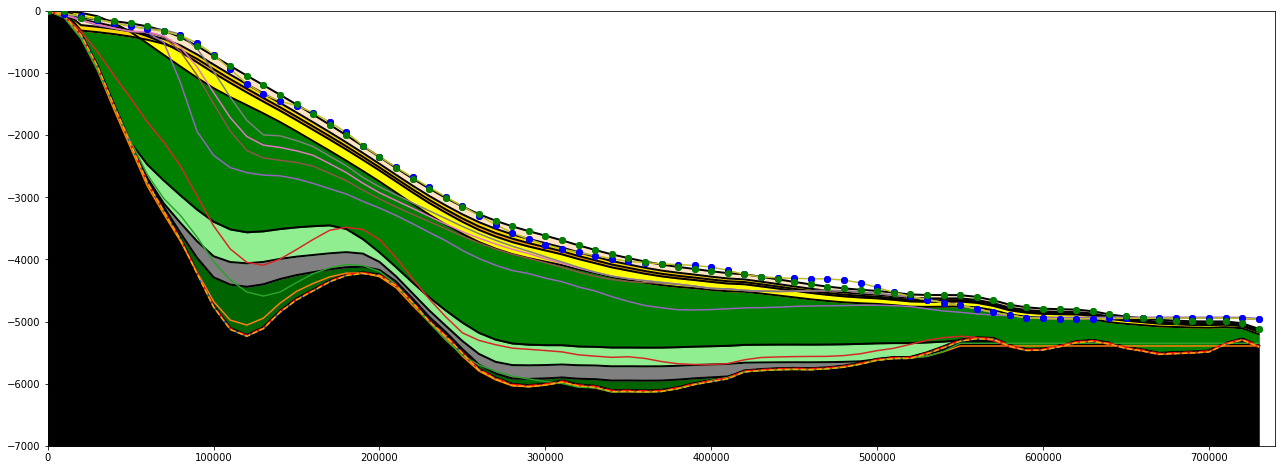

In [20]:
plt.figure(figsize=(22,8))
final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[-1, :], linewidth = 3, color = 'k')
    #plt.plot(out_ds.x, out_ds.profile__z[-1, :], linewidth = 3, color = 'k', linestyle='--')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
br_diff0000 = out_ds.profile__br[-1, :] - out_ds.profile__br[129, :]
br_diff000 = out_ds.profile__br[-1, :] - out_ds.profile__br[119, :]
br_diff00 = out_ds.profile__br[-1, :] - out_ds.profile__br[100, :]
br_diff0 = out_ds.profile__br[-1, :] - out_ds.profile__br[64, :]
br_diff1 = out_ds.profile__br[-1, :] - out_ds.profile__br[49, :]
br_diff2 = out_ds.profile__br[-1, :] - out_ds.profile__br[36, :]
br_diff3 = out_ds.profile__br[-1, :] - out_ds.profile__br[30, :]


br_diff4 = out_ds.profile__br[-1, :] - out_ds.profile__br[17, :]
plt.plot(out_ds.x, out_ds.profile__z[130, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[119, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[100, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[64, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[49, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[36, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[30, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[17, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

    #fill in all the strata
plt.fill_between(out_ds.x, out_ds.profile__br[-1, :], out_ds.profile__z[17, :] + br_diff4, color = 'darkgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[17, :] + br_diff4, out_ds.profile__z[30, :] + br_diff3, color = 'gray')
plt.fill_between(out_ds.x, out_ds.profile__z[30, :] + br_diff3, out_ds.profile__z[36, :] + br_diff2, color = 'lightgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[36, :] + br_diff2, out_ds.profile__z[49, :] + br_diff1, color = 'green')
plt.fill_between(out_ds.x, out_ds.profile__z[49, :] + br_diff1, out_ds.profile__z[64, :] + br_diff0, color = 'yellow')
plt.fill_between(out_ds.x, out_ds.profile__z[64, :] + br_diff0, out_ds.profile__z[100, :] + br_diff00, color = 'orange')
plt.fill_between(out_ds.x, out_ds.profile__z[100, :] + br_diff00, out_ds.profile__z[119, :] + br_diff000, color = 'gold')
plt.fill_between(out_ds.x, out_ds.profile__z[119, :] + br_diff000, out_ds.profile__z[129, :] + br_diff0000, color = 'bisque')
plt.fill_between(out_ds.x, -7000, out_ds.profile__br[-1, :], color = 'k')
    #plt.scatter(150000, sed_surfaces[8, 15], color = 'r')
plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
plt.scatter(200000, sed_surfaces[8, 20], color = 'r')

plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
plt.scatter(600000, sed_surfaces[8, 60], color = 'r')
#plt.scatter(1100000, sed_surfaces[8, 110], color = 'r')
 #plt.plot(out_ds.x, out_ds.profile__z[-110, :], linewidth = 3, color = 'g', linestyle=':')
plt.plot(out_ds.x, sed_surfaces[0, :])
plt.plot(out_ds.x, sed_surfaces[1, :])
plt.plot(out_ds.x, sed_surfaces[2, :])
plt.plot(out_ds.x, sed_surfaces[3, :])
plt.plot(out_ds.x, sed_surfaces[4, :])
plt.plot(out_ds.x, sed_surfaces[5, :])
plt.plot(out_ds.x, sed_surfaces[6, :])
plt.plot(out_ds.x, sed_surfaces[7, :])
plt.plot(out_ds.x, sed_surfaces[8, :])
#plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
#plt.scatter(200000, sed_surfaces[8, 20], color = 'r')
#plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
#plt.scatter(600000, sed_surfaces[8, 60], color = 'r', zorder = 5)
#plt.scatter(900000, sed_surfaces[8, 90], color = 'r')
plt.scatter(out_ds.x, sed_surfaces[8, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-1, :], color = 'g', zorder = 5)

plt.ylim(-7000, 0)
plt.xlim(0, 740000)
#plt.ylim(-7000, 0)
#plt.xlim(0, 1400000)
#model final bedrock
plt.plot(out_ds.x, out_ds.profile__br[-1, :], color = 'r', linestyle='-.')
#data final bedrock
plt.plot(out_ds.x, sed_surfaces[0, :], color = 'orange', linestyle='--')
plt.scatter(out_ds.x, sed_surfaces[-1, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-1, :], color = 'g', zorder = 5)
print(np.array(out_ds.profile__z[-1, 6]))

In [21]:
np.array(out_ds.profile__br[129, :])

array([    0.        ,   -80.03484677,  -379.58701699,  -891.23324486,
       -1522.44714143, -2138.52222726, -2752.5950842 , -3216.29510818,
       -3671.98366899, -4213.01769226, -4751.52334944, -5111.35923486,
       -5222.05505366, -5099.40611156, -4836.86550622, -4637.95387196,
       -4492.76367211, -4347.65900343, -4246.18339353, -4214.12007448,
       -4248.73459064, -4411.48837464, -4681.00957819, -4984.47914432,
       -5221.25186966, -5496.89148906, -5763.92887062, -5909.97977995,
       -6010.66906797, -6030.22098774, -6004.85670898, -5957.25452287,
       -6019.98491204, -6041.36629125, -6110.30081645, -6107.48493761,
       -6115.85957394, -6108.2936753 , -6062.22601221, -5996.96858003,
       -5951.12025026, -5904.44155018, -5794.23848815, -5772.79043859,
       -5758.70845958, -5752.99052127, -5757.49967464, -5744.35465266,
       -5717.43944923, -5669.47132619, -5607.20257447, -5579.2751437 ,
       -5577.23562348, -5503.74729325, -5406.86891551, -5301.09586584,
      

Show distributions of distance functions + compare their values pairwise in 2-d scatterplots

Using swath profile:

Using K-S statistic on independent distributions:

Using K-S statistic on landscape index distribution: